<h1>Geocoding Notebook - Sierra Leone<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Packages-and-functions" data-toc-modified-id="Packages-and-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Packages and functions</a></span></li><li><span><a href="#Prepare-and-match-admin-boundary-data" data-toc-modified-id="Prepare-and-match-admin-boundary-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare and match admin boundary data</a></span><ul class="toc-item"><li><span><a href="#Match-health-list-admin-names-to-shapefile-admin-names" data-toc-modified-id="Match-health-list-admin-names-to-shapefile-admin-names-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Match health list admin names to shapefile admin names</a></span><ul class="toc-item"><li><span><a href="#Match-orgunitlevel4-to-geoboundaries-Adm-3" data-toc-modified-id="Match-orgunitlevel4-to-geoboundaries-Adm-3-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Match orgunitlevel4 to geoboundaries Adm 3</a></span></li><li><span><a href="#Match-orgunitlevel3-to-FEWS-Adm-2" data-toc-modified-id="Match-orgunitlevel3-to-FEWS-Adm-2-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Match orgunitlevel3 to FEWS Adm 2</a></span></li></ul></li></ul></li><li><span><a href="#Match-to-locations-from-alternative-sources-based-on-facility-name" data-toc-modified-id="Match-to-locations-from-alternative-sources-based-on-facility-name-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Match to locations from alternative sources based on facility name</a></span><ul class="toc-item"><li><span><a href="#Health-Sites-IO" data-toc-modified-id="Health-Sites-IO-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Health Sites IO</a></span></li><li><span><a href="#RHINoVision-Master-Facility-List-Decision-Support-System" data-toc-modified-id="RHINoVision-Master-Facility-List-Decision-Support-System-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RHINoVision Master Facility List Decision Support System</a></span></li></ul></li><li><span><a href="#Geocoding-with-APIs" data-toc-modified-id="Geocoding-with-APIs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Geocoding with APIs</a></span><ul class="toc-item"><li><span><a href="#Facility-name-and-admin-3-names" data-toc-modified-id="Facility-name-and-admin-3-names-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Facility name and admin 3 names</a></span></li><li><span><a href="#Facility-name-and-admin-2-names" data-toc-modified-id="Facility-name-and-admin-2-names-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Facility name and admin 2 names</a></span></li><li><span><a href="#Admin-3-names" data-toc-modified-id="Admin-3-names-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Admin 3 names</a></span></li><li><span><a href="#Admin-3--and-admin-2-names" data-toc-modified-id="Admin-3--and-admin-2-names-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Admin 3  and admin 2 names</a></span></li></ul></li><li><span><a href="#Map-and-save-results" data-toc-modified-id="Map-and-save-results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Map and save results</a></span><ul class="toc-item"><li><span><a href="#Join-attributes-from-adminsitrative-polygons" data-toc-modified-id="Join-attributes-from-adminsitrative-polygons-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Join attributes from adminsitrative polygons</a></span></li></ul></li></ul></div>

Version: January 23, 2023

This notebook works with health facilities from the HMIS Database and attempts to geolocate them, by joining them to administrative shapefiles, other sources for health POI data, and running queries with geocoding APIs.

**Data Sources**
- Health facilities (hierarchy list)
- Geoboundaries (Adm1 through 4)
- FEWS Admin-2 boundaries (updated post 2017)
- Health Sites IO
- RHINoVision Master Facility List Decision Support System

# Packages and functions

In [164]:
import os, sys
import geopandas as gpd
import pandas as pd
from geopy.geocoders import GeoNames, Nominatim, Bing, GoogleV3
from shapely.geometry import Point
from tqdm import tqdm
from thefuzz import fuzz
from thefuzz import process
import matplotlib.pyplot as plt
from string import ascii_uppercase
import contextily as ctx
from os.path import join
import numpy as np
from dotenv import load_dotenv, find_dotenv

In [165]:
def remove_words(data_frame, column_name, words_to_remove = ['community', 'clinic', 'centre', 'center', 'hospital', 'health', 'government']):
    """ Remove words from strings in a specified column
    
    Args:
        data_frame: Pandas data frame
        column_name: Column name to remove words from
        words_to_remove: List of words

    Returns:
        Removes words in place

    """
    for word in words_to_remove:
        data_frame[column_name] = data_frame[column_name].str.replace(word, "")
    data_frame[column_name] = data_frame[column_name].str.strip()
        
def report_geocoding(records):
    """ Report value counts and % from geocoding_method column.
    
    Args:
        records: Pandas data frame

    Returns:
        Table with count stats 
    """
    table = records[['NAME', 'geocoding_method']].groupby('geocoding_method').count().rename(columns={'NAME':'count'})
    table.loc[:, "pct"] = table/(table['count'].sum())
    table = table.style.format({
        'pct': '{:,.1%}'.format,
    })
    return(table)

def match_name(name, list_names, min_score=0):
    """ Uses fuzzy matching between one string and a list of candidate names.
    
    Args:
        name: string
        list_names: list of candidate names to match
        min_score: minimum score allowed

    Returns:
        Returns name with the highest match, and match score
        If no match is higher than min score, returns "" and -1
    """
    # -1 score incase we don't get any matches
    max_score = -1
    # Returning empty name for no match as well
    max_name = ""
    # Iterating over all names in the other
    for name2 in list_names:
        #Finding fuzzy match score
        score = fuzz.ratio(name, name2)
        # Checking if we are above our threshold and have a better score
        if (score > min_score) & (score > max_score):
            max_name = name2
            max_score = score
    return (max_name, max_score)

def match_to_closest(row, gdf, column='ADMIN2'):
    """ Spatial join using closest distance algorithm.
    
    Args:
        row: row from geo data frame
        gdf: gdf with attributes to join
        column: attribute to join

    Returns:
        Returns specified attribute of closest feature
    """
    distances = [row.geometry.distance(pol) for pol in gdf.geometry]
    min_id = np.argmin(distances)
    closest = gdf.iloc[min_id]
    return closest[column]

def run_geocoding(idx, row, master_table, admin_area, components, country_code):
    """
    Geocoding workflow to be applied to each row in a dataset
    
    Args:
        idx: index
        row: row with index and names to geocode
        master_table: master table to store results
        admin_area: gdf of admin area to ensure result falls within
        components: list of names of attributes to use in query
        country_code: two letter iso code
    
    Returns:
        Stores geocoding results in master_table object
    """
    admin_bounds = admin_area.bounds
    bb = [(admin_bounds.iloc[0].miny, admin_bounds.iloc[0].minx), (admin_bounds.iloc[0].maxy, admin_bounds.iloc[0].maxx)]
    method = ' and '.join(components)
    items = [row[item] for item in components]
    query = ', '.join(items)
    
    geocoding_result = None
    geocoding_method = "None"
    # Try Geocoding with OSM
    try:
        res = geolocator_osm.geocode(query, country_codes=country_code)
        # if within admin
        if admin_area.contains(Point(res.longitude,res.latitude)).values[0] == True:
            geocoding_result = res
            geocoding_method = f"{method} query OSM"
        else:
            raise Exception("OSM point not valid or not within polygon")
    except:
        # Try Geocoding with Bing Maps
        try:
            res = geolocator_bing.geocode(query)
            # if within admin
            if admin_area.contains(Point(res.longitude,res.latitude)).values[0] == True:
                geocoding_result = res
                geocoding_method = f"{method} query Bing"
            else:
                raise Exception("Bing point not valid or not within polygon")
        except:
            # Try Geocoding with Google
            try:
                res = geolocator_google.geocode(query = query, region = country_code, bounds = bb)
                if res:
                    # if within admin
                    if admin_area.contains(Point(res.longitude,res.latitude)).values[0] == True:
                        geocoding_result = res
                        geocoding_method = f"{method} query Google"
            except:
                raise Exception("Google point not valid or not within polygon")
    
    master_table.loc[idx, "geocoding_method"] = geocoding_method
    if geocoding_result:
        master_table.loc[idx, "longitude"] = res.longitude
        master_table.loc[idx, "latitude"] = res.latitude

In [166]:
iso3 = "SLE"
country = "Sierra Leone"
input_dir = "/home/public/Data/PROJECTS/Health" 
output_dir = join(input_dir, "output")
# if not os.path.exists(out_folder):
#     os.mkdir(out_folder)

# Prepare and match admin boundary data 

In [167]:
geob4 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM4/geoBoundaries-{iso3}-ADM4.geojson")
geob3 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM3/geoBoundaries-{iso3}-ADM3.geojson")
geob2 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM2/geoBoundaries-{iso3}-ADM2.geojson")
geob1 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM1/geoBoundaries-{iso3}-ADM1.geojson")
fews2 = gpd.read_file(join(input_dir, 'FEWS', 'SLE', 'SL_Admin2_2017.shp'))

Text(0.5, 1.0, '4 ADM1 boundaries')

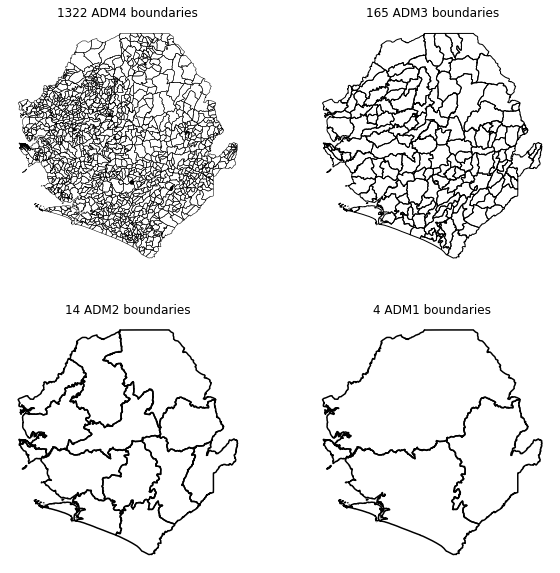

In [168]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
geob4.boundary.plot(ax=ax[0, 0], color='black', linewidth=0.5).set_axis_off()
ax[0, 0].set_title(f'{len(geob4)} ADM4 boundaries')
geob3.boundary.plot(ax=ax[0, 1], color='black', linewidth=1).set_axis_off()
ax[0, 1].set_title(f'{len(geob3)} ADM3 boundaries')
geob2.boundary.plot(ax=ax[1, 0], color='black').set_axis_off()
ax[1, 0].set_title(f'{len(geob2)} ADM2 boundaries')
geob1.boundary.plot(ax=ax[1, 1], color='black').set_axis_off()
ax[1, 1].set_title(f'{len(geob1)} ADM1 boundaries')
# plt.axis('off')

In [ ]:
master_table = pd.read_csv(os.path.join(input_dir, "tom_formatted", "hierarchy", "tom_edited_sierraleone_collapsed.csv"), encoding='utf-8')

In [ ]:
master_table.head(2)

,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,orgunitlevel5
0,Sierra Leone,Bo District,Bo City Council,Bo City,Aethel
1,Sierra Leone,Bo District,Bo City Council,Bo City,Agape Way


In [ ]:
len(master_table)

1564

In [ ]:
print(f"Unique Level 2: {len(master_table.orgunitlevel2.unique())}")
print(f"Unique Level 3: {len(master_table.orgunitlevel3.unique())}")
print(f"Unique Level 4: {len(master_table.orgunitlevel4.unique())}")
print(f"Unique Level 5: {len(master_table.orgunitlevel5.unique())}")

Unique Level 2: 16
Unique Level 3: 22
Unique Level 4: 208
Unique Level 5: 1556


In [ ]:
print(f"Unique Geoboundaries Adm 1: {len(geob1)}")
print(f"Unique Geoboundaries Adm 2: {len(geob2)}")
print(f"Unique Geoboundaries Adm 3: {len(geob3)}")
print(f"Unique Geoboundaries Adm 4: {len(geob4)}")

Unique Geoboundaries Adm 1: 4
Unique Geoboundaries Adm 2: 14
Unique Geoboundaries Adm 3: 165
Unique Geoboundaries Adm 4: 1322


# To-do: Abstract the admin and shapefile names

## Match health list admin names to shapefile admin names
### Match orgunitlevel4 to geoboundaries Adm 3
Try using fuzzy matching  

In [ ]:
level4_list = list(master_table.orgunitlevel4.unique())
level4_list.sort()
geob3_list = list(geob3.shapeName)
geob3_list.sort()

Print names one at a time for both datasets one letter at a time, and manually inspect

In [ ]:
for letter in ascii_uppercase:
    level4_sublist = [name for name in level4_list if name[0]==letter]
    geob3_sublist = [name for name in geob3_list if name[0]==letter]

    if len(level4_sublist)>0:
        print("Master list level 4")
        print("\t"+str(level4_sublist))
    if len(geob3_sublist) >0:
        print("Geoboundaries adm3")
        print("\t"+str(geob3_sublist))
        
    print("\n")



Master list level 4
	['Badjia', 'Bagbwe', 'Bagruwa', 'Bake-Loko', 'Baoma', 'Barawa Wollay', 'Bargbo', 'Barri', 'Bendu-Cha', 'Biriwa', 'Bo City', 'Bombali Sebora', 'Bombali Serry', 'Bongor', 'Bonthe Town', 'Bramaia', 'Bum', 'Bumpe Ngao', 'Bumpeh', 'Bureh', 'Buya']
Geoboundaries adm3
	['Badjia', 'Bagbo', 'Bagbwe(Bagbe)', 'Bagruwa', 'Barri', 'Bendu-Cha', 'Biriwa', 'Bo Town', 'Boama', 'Bombali Sebora', 'Bonthe Urban', 'Bramaia', 'Bum', 'Bumpe Ngao', 'Bumpeh', 'Bureh Kasseh Ma', 'Buya Romende']


Master list level 4
	['Central 1 Zone', 'Central 2 Zone']
Geoboundaries adm3
	['Central I', 'Central II']


Master list level 4
	['Dama', 'Dansogoia', 'Dasse', 'Dea', 'Delmandugu', 'Dema', 'Dembelia-Sinkunia', 'Diang', 'Dibia', 'Dixon', 'Dodo']
Geoboundaries adm3
	['Dama', 'Dasse', 'Dea', 'Dema', 'Dembelia - Sink', 'Diang', 'Dibia', 'Dodo']


Master list level 4
	['East 1 Zone', 'East 2 Zone', 'East 3 Zone']
Geoboundaries adm3
	['East I', 'East II', 'East III']


Master list level 4
	['Fakunya', 

Manually adjust spellings of master health list to create more matches.

In [ ]:
master_table.loc[:, "orgunitlevel4_edit"] = master_table.orgunitlevel4

In [ ]:
# master_table.loc[master_table.orgunitlevel4 == "Bo City", "orgunitlevel4_edit"] = "Bo Town"
master_table.loc[master_table.orgunitlevel4 == "Central 1 Zone", "orgunitlevel4_edit"] = "Central I"
master_table.loc[master_table.orgunitlevel4 == "Central 2 Zone", "orgunitlevel4_edit"] = "Central II"
master_table.loc[master_table.orgunitlevel4 == "East 1 Zone", "orgunitlevel4_edit"] = "East I"
master_table.loc[master_table.orgunitlevel4 == "East 2 Zone", "orgunitlevel4_edit"] = "East II"
master_table.loc[master_table.orgunitlevel4 == "East 3 Zone", "orgunitlevel4_edit"] = "East III"
master_table.loc[master_table.orgunitlevel4 == "West 1 Zone", "orgunitlevel4_edit"] = "West I"
master_table.loc[master_table.orgunitlevel4 == "West 2 Zone", "orgunitlevel4_edit"] = "West II"
master_table.loc[master_table.orgunitlevel4 == "West 3 Zone", "orgunitlevel4_edit"] = "West III"
master_table.loc[master_table.orgunitlevel4 == "Bagbwe", "orgunitlevel4_edit"] = "Bagbwe(Bagbe)"

Remove key words that confuse matching algorithm

In [ ]:
remove_words(geob3, "shapeName", ['Town', 'City', 'Urban', 'Zone'])
remove_words(master_table, "orgunitlevel4_edit", ['Town', 'City', 'Urban', 'Zone'])

In [ ]:
# level4_list = list(master_table.orgunitlevel4.unique())
level4_list = list(master_table.orgunitlevel4_edit.unique())
level4_list.sort()
geob3_list = list(geob3.shapeName)
geob3_list.sort()

In [ ]:
# List for dicts for easy dataframe creation
dict_list = []
# iterating over orgunitlevel4_edit list
for name in level4_list:
    
    # Use our method to find best match, we can set a threshold here
    match = match_name(name, geob3_list, 30)

    # New dict for storing data
    dict_ = {}
    dict_.update({"name_level4" : name})
    dict_.update({"name_geob3" : match[0]})
    dict_.update({"score" : match[1]})
    dict_list.append(dict_)

table_adm3 = pd.DataFrame(dict_list)
table_adm3_matches = table_adm3[table_adm3.score > 70].copy()

In [ ]:
matches_pct = (len(table_adm3_matches) / len(level4_list))
'{:.2f}%'.format(matches_pct*100)

'78.37%'

In [ ]:
# could save this list for someone to confirm matches manually
# for now take input noting which ones should be dropped based on quick inspection
table_adm3_matches.loc[table_adm3_matches.score<=80]

,name_level4,name_geob3,score
4,Baoma,Boama,80
13,Bongor,Mongo,73
19,Bureh,Bumpeh,73
24,Dansogoia,Kalansogoia,80
40,Folosaba Kamba,Folosaba Dembel,76
42,Galliness,Galliness Perri,75
47,Gbanti (Karene),Gbanti Kamarank,73
48,Gbendembu,Gbendembu Ngowa,75
54,Gbokolenken Polie,Gbonkolenken,76
55,Gbokolenken Yele,Gbonkolenken,79


In [ ]:
for idx, row in table_adm3_matches.loc[table_adm3_matches.score<=80].iterrows():
    print(row)
    print('\n')
    drop_input = input("Drop? If no, leave blank: ")
    if len(drop_input)>0:
        table_adm3_matches.drop(idx, axis=0, inplace=True)

name_level4    Baoma
name_geob3     Boama
score             80
Name: 4, dtype: object




In [ ]:
matches_pct = (len(table_adm3_matches) / len(level4_list))
'{:.2f}%'.format(matches_pct*100)

### Match orgunitlevel2 to FEWS Adm 2

In [ ]:
master_table.loc[:, "orgunitlevel2_edit"] = master_table.orgunitlevel2

In [ ]:
# remove_words(geob2, "admin2Name", [" City Council", " District Council", " Municipal Council"])
remove_words(master_table, "orgunitlevel2_edit", [" District"])
remove_words(fews2, "ADMIN2", [" City Council", " District Council", " Municipal Council"])

In [ ]:
level2_list = list(master_table.orgunitlevel2_edit.unique())
level2_list.sort()
geob2_list = list(geob2.admin2Name)
geob2_list.sort()
fews2_list = list(fews2.ADMIN2)
fews2_list.sort()

Print names one at a time for both datasets one letter at a time, and manually inspect

In [ ]:
for letter in ascii_uppercase:
    level2_sublist = [name for name in level2_list if name[0]==letter]
    #geob2_sublist = [name for name in geob2_list if name[0]==letter]
    fews2_sublist = [name for name in fews2_list if name[0]==letter]
    if len(level2_sublist)>0:
        print("Master list level 2")
        print("\t"+str(level2_sublist))
#     if len(geob2_sublist) >0:
#         print("Geoboundaries adm2")
#         print("\t"+str(geob2_sublist))
    if len(fews2_sublist) > 0:
        print("FEWS adm2")
        print("\t"+str(fews2_sublist))
    print("\n")

In [ ]:
# List for dicts for easy dataframe creation
dict_list = []
# iterating over our players without salaries found above
for name in level2_list:
    
    # Use our method to find best match, we can set a threshold here
    match = match_name(name, fews2_list, 30)

    # New dict for storing data
    dict_ = {}
    dict_.update({"name_level2" : name})
    dict_.update({"name_fews2" : match[0]})
    dict_.update({"score" : match[1]})
    dict_list.append(dict_)

table_adm2 = pd.DataFrame(dict_list)
table_adm2_matches = table_adm2[table_adm2.score > 75]

In [ ]:
matches_pct = (len(table_adm2_matches) / len(level2_list))
'{:.2f}%'.format(matches_pct*100)

Loop through each row in master table, and add new attribute names (adm3 and adm2), if the names produced matches in the lookup tables

In [ ]:
master_table_copy = master_table.copy()

In [ ]:
for idx, row in master_table_copy.iterrows():
    
    if row.orgunitlevel4_edit in list(table_adm3_matches.name_level4):
        
        match = table_adm3_matches.loc[table_adm3_matches.name_level4==row.orgunitlevel4_edit, "name_geob3"].iloc[0]
        master_table_copy.loc[idx, 'adm3'] = match
        
    if row.orgunitlevel2_edit in list(table_adm2_matches.name_level2):
        
        match = table_adm2_matches.loc[table_adm2_matches.name_level2==row.orgunitlevel2_edit, "name_fews2"].iloc[0]
        master_table_copy.loc[idx, 'adm2'] = match

In [ ]:
master_table_copy.adm2.isna().sum()

In [ ]:
master_table_copy.adm3.isna().sum()

In [ ]:
master_table_copy.head(2)

# Match to locations from alternative sources based on facility name


## Health Sites IO
Import Health Sites from HealthSites.io  
Health sites come in both a node and a way shapefile. You need to import both to get all the sites.  
In QGIS, I created centroids from the ways then merged it with the points.

In [ ]:
nodes_io = gpd.read_file(os.path.join(input_dir, "healthsitesio", "SLE", "merged_SLR_healthsites_pts.shp"))

In [ ]:
nodes_io = nodes_io.loc[~nodes_io.name.isna()].copy()

In [ ]:
nodes_io['name'] = nodes_io['name'].str.lower()

In [ ]:
words_to_remove = ['community', 'clinic', 'centre', 'center', 'hospital', 'health', 'government']

In [ ]:
records = master_table_copy.copy()
records['NAME'] = records['orgunitlevel5'].str.lower()

In [ ]:
remove_words(nodes_io, 'name', words_to_remove)
remove_words(records, 'NAME', words_to_remove)

In [ ]:
records['geocoding_method'] = "None"

In [ ]:
for idx, row in tqdm(records.iterrows()):
    
    # Check if there is another entry with location
    match, score = match_name(row.NAME, list(nodes_io['name']), 75)
#     match, score = match_name(row.name_concat, list(nodes_io.name_concat), 85)
    
    if score > 0:
        print(row.NAME, match)
        matching_row = nodes_io.loc[nodes_io['name']==match].copy()
        res = matching_row.iloc[0]
        
        if not pd.isna(row.adm3):
            adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
            if adm3.contains(res.geometry).values[0] == True:
                records.loc[idx, "longitude"] = res.geometry.x
                records.loc[idx, "latitude"] = res.geometry.y
                records.loc[idx, "geocoding_method"] = "Location from Health Sites IO"
        else:
            adm2 = geob2.loc[geob2['admin2Name'] == row['adm2']].copy() if row.adm2 in geob2_list else fews2.loc[fews2['ADMIN2'] == row['adm2']].copy()
            if adm2.contains(res.geometry).values[0] == True:            
                records.loc[idx, "longitude"] = res.geometry.x
                records.loc[idx, "latitude"] = res.geometry.y
                records.loc[idx, "geocoding_method"] = "Location from Health Sites IO"

In [ ]:
report_geocoding(records)

## RHINoVision Master Facility List Decision Support System

In [ ]:
#rhino = pd.read_excel(os.path.join(input_dir, "rhino", "00 SSA MFL (130219).xlsx"), 0)
rhino = pd.read_csv(os.path.join(input_dir, "rhino", "00 SSA MFL (130219).csv"))

In [ ]:
rhino = rhino.loc[rhino.Country=="Sierra Leone"].copy()

In [ ]:
rhino['name'] = rhino['Facility name'].str.lower()

In [ ]:
remove_words(rhino, 'name')

In [ ]:
rhino.loc[:, "geometry"] = rhino.apply(lambda x: Point(x.Long, x.Lat), axis=1)
rhino = gpd.GeoDataFrame(rhino, geometry='geometry', crs='EPSG:4326')

In [ ]:
for idx, row in tqdm(records.iterrows()):
    
    if row.geocoding_method=="None":
        
        # Check if there is another entry with location
        match, score = match_name(row.NAME, list(rhino['name']), 75)

        if score > 0:
            print(row.NAME, match)
            matching_row = rhino.loc[rhino['name']==match].copy()
            res = matching_row.iloc[0]
            
            if not pd.isna(row.adm3):
                adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
                if adm3.contains(res.geometry).values[0] == True:
                    records.loc[idx, "longitude"] = res.geometry.x
                    records.loc[idx, "latitude"] = res.geometry.y
                    records.loc[idx, "geocoding_method"] = "Location from Rhino Dataset"
                    records.loc[idx, "source"] = res["LL source"]
            else:
                adm2 = geob2.loc[geob2['admin2Name'] == row['adm2']].copy() if row.adm2 in geob2_list else fews2.loc[fews2['ADMIN2'] == row['adm2']].copy()
                if adm2.contains(res.geometry).values[0] == True:            
                    records.loc[idx, "longitude"] = res.geometry.x
                    records.loc[idx, "latitude"] = res.geometry.y
                    records.loc[idx, "geocoding_method"] = "Location from Rhino Dataset"
                    records.loc[idx, "source"] = res["LL source"]

In [ ]:
report_geocoding(records)

# Geocoding with APIs

In [ ]:
from pathlib import Path 
env_path = Path(input_dir) / '.env'
load_dotenv(dotenv_path=env_path)

In [ ]:
bing_key = os.environ.get("bing_key")
google_key = os.environ.get("google_key")

In [ ]:
geolocator_osm = Nominatim(user_agent="health-equity")
geolocator_bing = Bing(api_key=bing_key)
geolocator_google = GoogleV3(api_key=google_key)

## Facility name and admin 3 names

Geocode based on facility name (orgunitlevel5) + admin 3 name.  
Check to make sure result falls within admin 3 polygon.

In [ ]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
# only include trying to geocode rows that have an admin name that is matched to the Geoboundaries file
records_subset = records_subset.loc[~records_subset.adm3.isna()].copy()

In [ ]:
len(records_subset)

In [ ]:
records_subset.head(2)

In [ ]:
for idx, row in tqdm(records_subset.iterrows()):
    
    adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
    run_geocoding(idx, row, records, adm3, ['NAME', 'adm3'], 'sl')

In [ ]:
report_geocoding(records)

In [ ]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
records_subset = records_subset.loc[~records_subset.adm3.isna()].copy()

In [ ]:
len(records_subset)

## Facility name and admin 2 names

Geocode based on facility name (orgunitlevel5) + admin 2 name.  
Check to make sure result falls within admin 3 polygon.

In [ ]:
for idx, row in tqdm(records_subset.iterrows()):
    
    adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
    run_geocoding(idx, row, records, adm3, ['NAME', 'adm2'], 'sl')

In [ ]:
report_geocoding(records)

In [ ]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
records_subset = records_subset.loc[~records_subset.adm3.isna()].copy()

In [ ]:
len(records_subset)

## Admin 3 names

Geocode based on admin 3 name.  
Check to make sure result falls within admin 3 polygon.  
If no result use admin 3 centroid.

In [ ]:
orglev4_df = records_subset[['orgunitlevel4', 'orgunitlevel4_edit', 'adm3', 'orgunitlevel1']].drop_duplicates().copy()

In [ ]:
orglev4_df.head(2)

In [ ]:
len(orglev4_df)

In [ ]:
for idx, row in tqdm(orglev4_df.iterrows()):
    
    adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
    run_geocoding(idx, row, orglev4_df, adm3, ['orgunitlevel4', 'orgunitlevel1'], 'sl')

In [ ]:
for idx, row in tqdm(orglev4_df.iterrows()):
    
    #grab admin geometry
    adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
    if row.geocoding_method=="None":
        cent = adm3.geometry.representative_point().iloc[0]
        orglev4_df.loc[idx, "longitude"] = cent.x
        orglev4_df.loc[idx, "latitude"] = cent.y
        orglev4_df.loc[idx, "geocoding_method"] = "District centroid"

In [ ]:
orglev4_df.geocoding_method.value_counts()

In [ ]:
for idx, row in tqdm(records_subset.iterrows()):
    
    orglev4_geocoded = orglev4_df.loc[orglev4_df['orgunitlevel4']==row['orgunitlevel4']].iloc[0]    
    records.loc[idx, "longitude"] = orglev4_geocoded.longitude
    records.loc[idx, "latitude"] = orglev4_geocoded.latitude
    records.loc[idx, "geocoding_method"] = orglev4_geocoded.geocoding_method

In [ ]:
report_geocoding(records)

In [ ]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
# records_subset = records.loc[records.adm3.isna()].copy()

In [ ]:
len(records_subset)

## Admin 3  and admin 2 names

Geocode based on admin 3 name and admin 2 name.    
Check to make sure result falls within admin 2 polygon.  

In [ ]:
orglev4_df = records_subset[['orgunitlevel4', 'orgunitlevel4_edit', 'adm2', 'orgunitlevel1']].drop_duplicates().copy()

In [ ]:
len(orglev4_df)

In [ ]:
for idx, row in tqdm(orglev4_df.iterrows()):
    
    adm2 = geob2.loc[geob2['admin2Name'] == row['adm2']].copy() if row.adm2 in geob2_list else fews2.loc[fews2['ADMIN2'] == row['adm2']].copy()
    run_geocoding(idx, row, orglev4_df, adm2, ['orgunitlevel4', 'adm2'], 'sl')

In [ ]:
orglev4_df.geocoding_method.value_counts()

In [ ]:
for idx, row in tqdm(records_subset.iterrows()):
    
    orglev4_geocoded = orglev4_df.loc[orglev4_df['orgunitlevel4']==row['orgunitlevel4']].iloc[0]    
    records.loc[idx, "longitude"] = orglev4_geocoded.longitude
    records.loc[idx, "latitude"] = orglev4_geocoded.latitude
    records.loc[idx, "geocoding_method"] = orglev4_geocoded.geocoding_method

In [ ]:
report_geocoding(records)

In [ ]:
records_subset = records.loc[records.geocoding_method=="None"].copy()

In [ ]:
len(records_subset)

# Map and save results

In [ ]:
results = records.copy()

In [ ]:
results.geocoding_method.unique()

In [ ]:
# facility name and adm 3
results.loc[results.geocoding_method=="NAME and adm3 query Bing", "geocoding_method"] = "orgunitlevel5 and adm3 query"
results.loc[results.geocoding_method=="NAME and adm3 query OSM", "geocoding_method"] = "orgunitlevel5 and adm3 query"
results.loc[results.geocoding_method=="NAME and adm3 query Google", "geocoding_method"] = "orgunitlevel5 and adm3 query"

# facility name and adm 2
results.loc[results.geocoding_method=="NAME and adm2 query Bing", "geocoding_method"] = "orgunitlevel5 and adm2 query"
results.loc[results.geocoding_method=="NAME and adm2 query OSM", "geocoding_method"] = "orgunitlevel5 and adm2 query"
results.loc[results.geocoding_method=="NAME and adm2 query Google", "geocoding_method"] = "orgunitlevel5 and adm2 query"

# adm 3 name
results.loc[results.geocoding_method=="orgunitlevel4 and orgunitlevel1 query Bing", "geocoding_method"] = "orgunitlevel4 query"
results.loc[results.geocoding_method=="orgunitlevel4 and orgunitlevel1 query OSM", "geocoding_method"] = "orgunitlevel4 query"
results.loc[results.geocoding_method=="orgunitlevel4 and orgunitlevel1 query Google", "geocoding_method"] = "orgunitlevel4 query"

# adm 3 name and adm2
results.loc[results.geocoding_method=="orgunitlevel4 and adm2 query Bing", "geocoding_method"] = "orgunitlevel4 and adm2 query"
results.loc[results.geocoding_method=="orgunitlevel4 and adm2 query OSM", "geocoding_method"] = "orgunitlevel4 and adm2 query"
results.loc[results.geocoding_method=="orgunitlevel4 and adm2 query Google", "geocoding_method"] = "orgunitlevel4 and adm2 query"

# Centroid
results.loc[results.geocoding_method=="District centroid", "geocoding_method"] = "Adm3 centroid"

In [ ]:
report_geocoding(results)

In [ ]:
results.loc[:, "geometry"] = results.apply(lambda x: Point(x.longitude, x.latitude), axis=1)
results = gpd.GeoDataFrame(results, geometry='geometry', crs='EPSG:4326')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
geob3.boundary.plot(ax=ax, color='black', linewidth=1).set_axis_off()
results.loc[results.geocoding_method!="None"].plot(ax=ax, column='geocoding_method', edgecolor='white', markersize=50, alpha=0.75, legend=True)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10)

## Join attributes from adminsitrative polygons

Join admin data back to results.  
For adm3 features, use spatial join to geob3.  

In [ ]:
results2 = results.loc[~(results.longitude.isna())].copy()

In [ ]:
results2 = gpd.sjoin(results2, geob3[["shapeName", "shapeID", "geometry"]], how='left', predicate='intersects')
results2.drop('index_right', axis=1, inplace=True)

For adm2 features, use spatial join to geob2 first (excluding regions that were divided in 2017)  
Then use closest algorithm using FEWS NET adm 2 file.  
Ideally, we would just use the FEWS file, but it's resolution is not good enough to do intersects in border areas.

In [ ]:
geob2_copy = geob2.copy()

In [ ]:
idx_drop = geob2_copy.loc[geob2_copy.admin2Name.isin(['Bombali', 'Koinadugu'])].index

In [ ]:
geob2_copy.drop(idx_drop, axis=0, inplace=True)

In [ ]:
results2 = gpd.sjoin(results2, geob2_copy[["admin2Name", "geometry"]], how='left', predicate='intersects')
results2.drop('index_right', axis=1, inplace=True)

In [ ]:
results2.loc[results2.admin2Name.isna(), "admin2Name"] = results2.loc[results2.admin2Name.isna()].apply(lambda x: match_to_closest(x, fews2, "ADMIN2"), axis=1)

In [ ]:
results2.shapeName.isna().sum(), results2.admin2Name.isna().sum()

In [ ]:
# results2.loc[results2.adm3!=results2.shapeName]

In [ ]:
results2.rename(
    columns={
        'shapeName':'geob_adm3',
        'shapeID':'geob_adm3_id',
        'admin2Name':'fews_adm2',
        'adm2':'fuzzy_match_adm2',
        'adm3':'fuzzy_match_adm3'
    }, inplace=True)

In [ ]:
#results2.to_file(join(output_dir, "SLE_geocoding_1.24.23.json"), driver='GeoJSON', index=True)

In [ ]:
# geob3.to_file(join(output_dir, "SLE_geob3.json"), driver='GeoJSON')

In [ ]:
#
results2.to_csv(join(output_dir, "SLE_geocoding_1.24.23.csv"))